# Autoencoder approach: predict part of plant

## Contents
- [1. Imports](#1.-Imports)
- [2. Build models](#2.-Build-models)
- [3. Encode data with computed autoencoders](#3.-Encode-data-with-computed-autoencoders)
- [4. Logistic regression classifier with encoded data](#4.-Logistic-regression-classifier-with-encoded-data)
- [5. Gaussian Naive Bayes classifier with encoded data](#5.-Gaussian-Naive-Bayes-classifier-with-encoded-data)
- [6. Hybrid Bayesian classifier with bnlearn](#6.-Hybrid-Bayesian-classifier-with-bnlearn)


[Back to Chemfin](../Chemfin.ipynb)

### 1. Imports
The first cell with code includes all necessary inputs.

Requires [numpy](http://www.numpy.org/), [scikit-learn](http://scikit-learn.org/), [pyTorch](http://pytorch.org/), [Rpy2](https://rpy2.readthedocs.io).

[Back to contents](#Contents)

In [1]:
import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
print(mkl_rt.mkl_get_max_threads())
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
def mkl_set_num_threads(cores):
    mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(cores)))

mkl_set_num_threads(4)
print(mkl_get_max_threads())

16
4


In [2]:
%env MKL_NUM_THREADS=4
%env OMP_NUM_THREADS=4

env: MKL_NUM_THREADS=4
env: OMP_NUM_THREADS=4


In [1]:
import sys
sys.path.append('../src/')
import copy

import numpy as np
import os
import torch
torch.set_num_threads(4);
from torch import nn
torch.set_num_threads(4);
from torch.autograd import Variable
from torch.utils.data import DataLoader

import autoencoder as ae

random_state = 150
torch.manual_seed(random_state);
torch.set_num_threads(4);


from computational_utils import reshape
import bayesian_networks as bn

from io_work import stringSplitByNumbers

import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from computational_utils import reshape
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import rpy2.robjects.numpy2ri
import rpy2.robjects.pandas2ri
from rpy2.robjects.packages import importr


### 2. Build models

Next cell contains script to build autoencoder models relevant to CV indexes supplied by data/cv_indices.npz.

Parameters to control are:

- sizes: list of integers which specifies output sizes for each encoding layer
- batch_size: number of samples to be used for computing new update at each epoch
- nEpoch: number of epochs for each layer
- num_workers: number of parallel processes to work

[Back to contents](#Contents)

In [ ]:
data_dirname = '../data/'
model_dirname = '../models/autoencoder/'
filename_dataset = 'dataset_parts.npz'
#filename_cv = 'cv_indices_parts.npz'
filename_cv = 'physical_cv_indices_parts.npz'

model_filename_prefix = 'parts_model_ae_'

df = np.load(data_dirname+filename_dataset)
T, labels = df['data'], df['label']
# unfold into matrix
T = reshape(T, [T.shape[0], -1])
# normalize among samples
T /= np.linalg.norm(T, axis=1, keepdims=1)
print 'full'
    
sizes = [400, 100, 25]
nEpoch = [1000, 1000, 1000]
batch_size = 200
num_workers = 1

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']



ae.buildAutoencoderModels(
    T, train_indices, test_indices, sizes, model_dirname, nEpoch,
    batch_size, num_workers, model_filename_prefix
)

full
============= CV 1 / 20 ================
(1) Errors on training set (1698 samples): 
min=8.206e-02 / mean=1.448e-01 / median=1.401e-01 / max=3.279e-01
(1) Errors on validation set (165 samples): 
min=9.478e-02 / mean=2.431e-01 / median=2.113e-01 / max=7.176e-01
(2) Errors on training set (1698 samples): 
min=5.168e-02 / mean=9.265e-02 / median=8.957e-02 / max=2.045e-01
(2) Errors on validation set (165 samples): 
min=5.709e-02 / mean=2.271e-01 / median=1.929e-01 / max=6.879e-01
(3) Errors on training set (1698 samples): 
min=5.211e-02 / mean=1.099e-01 / median=1.067e-01 / max=2.894e-01
(3) Errors on validation set (165 samples): 
min=5.991e-02 / mean=2.827e-01 / median=2.415e-01 / max=8.670e-01
============= CV 2 / 20 ================
(1) Errors on training set (1668 samples): 
min=7.986e-02 / mean=1.449e-01 / median=1.398e-01 / max=3.308e-01
(1) Errors on validation set (164 samples): 
min=9.271e-02 / mean=2.557e-01 / median=2.206e-01 / max=6.706e-01
(2) Errors on training set (1

### 3. Encode data with computed autoencoders

[Back to contents](#Contents)

In [5]:
data_dirname = '../data/'
model_dirname = '../models/autoencoder/'
model_filename_prefix = 'parts_model_ae_'
filename_dataset = 'dataset_parts.npz'
test2_filename_dataset = 'test2_parts.npz'
save_filename_test2 = 'autoencoded_' + test2_filename_dataset
save_filename = 'autoencoded_' + filename_dataset

sizes = [400, 100, 25]
num_workers = 1


df = np.load(data_dirname+filename_dataset)
ae.encodeDataset(
    df, sizes, model_dirname, model_filename_prefix,
    data_dirname+save_filename, num_workers, return_result=0
)

df = np.load(data_dirname+test2_filename_dataset)
ae.encodeDataset(
    df, sizes, model_dirname, model_filename_prefix,
    data_dirname+save_filename_test2, num_workers, return_result=0
)

encoded with parts_model_ae_0. Comp.time=0.35480
encoded with parts_model_ae_1. Comp.time=0.23906
encoded with parts_model_ae_2. Comp.time=0.24196
encoded with parts_model_ae_3. Comp.time=0.23964
encoded with parts_model_ae_4. Comp.time=0.24368
encoded with parts_model_ae_5. Comp.time=0.24380
encoded with parts_model_ae_6. Comp.time=0.23982
encoded with parts_model_ae_7. Comp.time=0.23961
encoded with parts_model_ae_8. Comp.time=0.24224
encoded with parts_model_ae_9. Comp.time=0.23963
encoded with parts_model_ae_10. Comp.time=0.26648
encoded with parts_model_ae_11. Comp.time=0.23974
encoded with parts_model_ae_12. Comp.time=0.24172
encoded with parts_model_ae_13. Comp.time=0.23897
encoded with parts_model_ae_14. Comp.time=0.23919
encoded with parts_model_ae_15. Comp.time=0.23927
encoded with parts_model_ae_16. Comp.time=0.23897
encoded with parts_model_ae_17. Comp.time=0.23893
encoded with parts_model_ae_18. Comp.time=0.23964
encoded with parts_model_ae_19. Comp.time=0.23897
encoded wi

### 4. Logistic regression classifier with encoded data

[Back to contents](#Contents)

In [6]:
data_dirname = '../data/'
dirname_results = '../results/'
filename_results = 'autoencoder+LR_parts'
data_filename = 'autoencoded_dataset_parts.npz'
data_test2_filename = 'autoencoded_test2_parts.npz'

#filename_cv = 'cv_indices_parts.npz'
filename_cv = 'physical_cv_indices_parts.npz'

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']

df = np.load(data_dirname+data_test2_filename)
X_test2, y_test2 = df['data'], df['label']
y_test2 = reshape(y_test2, [-1, 1])

df = np.load(data_dirname+data_filename)
X, y = df['data'], df['label']
y = reshape(y, [-1, 1])
colnames = ['identity'] + ['V%d' % (i) for i in xrange(X.shape[-1])]

tms = []
predict_train_all = []
predict_test_all = []
predict_test2_all = []

confusion_matrices = []
accuracies = []
f1s = []

# correct label in the end
predicted_probas_test = []
predicted_probas_test2 = []
for k in xrange(len(train_indices)):
    #print "CV %d / %d" % (k+1, len(train_indices))
    train_index = train_indices[k]
    test_index = test_indices[k]
    
    classifier = LogisticRegression(
        penalty='l1', dual=False, tol=0.0001, C=1000.0, fit_intercept=True,
        intercept_scaling=1, class_weight=None, random_state=None,
        solver='saga', max_iter=1000, multi_class='multinomial', verbose=0,
        warm_start=False, n_jobs=1
    )
    
    tic = time.clock();
    classifier.fit(X[k][train_index], y[train_index])
    toc = time.clock();
    
    tms_loc = [toc-tic]
    
    tic = time.clock()
    predict_train = classifier.predict(X[k][train_index])
    toc = time.clock()
    tms_loc.append(toc-tic)
    acc_loc = [accuracy_score(y[train_index], predict_train)]
    f1_loc = [f1_score(y[train_index], predict_train, average='weighted')]
    tic = time.clock()
    predict_test = classifier.predict(X[k][test_index])
    toc = time.clock()
    acc_loc.append( accuracy_score(y[test_index], predict_test) )
    f1_loc.append(f1_score(y[test_index], predict_test, average='weighted') )
    confusion_matrices.append(
        confusion_matrix(y[test_index], predict_test, labels=np.unique(y[train_index]))
    )
    tms_loc.append(toc-tic)
    
    tmp = reshape(np.array(y[test_index]), [-1, 1])
    tmp = np.hstack([classifier.predict_proba(X[k][test_index]), tmp])
    predicted_probas_test.append( tmp.copy() )
    tmp = reshape(np.array(y_test2), [-1, 1])
    tmp = np.hstack([classifier.predict_proba(X_test2[k]), tmp])
    predicted_probas_test2.append( tmp.copy() )
    
    predict_test2 = classifier.predict(X_test2[k])
    acc_loc.append( accuracy_score(y_test2, predict_test2) )
    f1_loc.append(f1_score(y_test2, predict_test2, average='weighted') )
    
    accuracies.append(acc_loc)
    f1s.append(f1_loc)
    tms.append(tms_loc)
    predict_train_all.append( predict_train )
    predict_test_all.append( predict_test )
    predict_test2_all.append( predict_test2 )
    np.savez_compressed(
        dirname_results+filename_results, tms=tms, predict_train=predict_train_all,
        predict_test=predict_test_all, test_indices=test_indices,
        train_indices=train_indices, y=y, confusion_matrices=confusion_matrices,
        acc=accuracies, f1=f1s, predicted_probas_test=predicted_probas_test,
        predicted_probas_test2=predicted_probas_test2, predict_test2=predict_test2_all
    )

accuracies
[0.8783225  0.7808689  0.65909091]
f1 measure
[0.87593769 0.77934129 0.60957189]


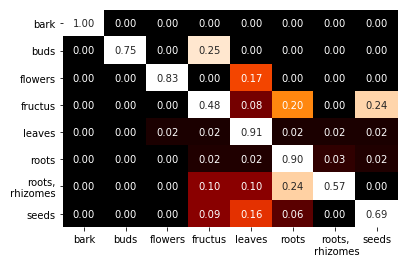

In [2]:
dirname_results = '../results/'
filename_results = 'autoencoder+LR_parts.npz'

df = np.load(dirname_results+filename_results)

confusion_matrices = df['confusion_matrices']
confusion_matrices = np.array(confusion_matrices)
medCMs = np.median(confusion_matrices, axis=0)

accuracies = df['acc']
accuracies = np.array(accuracies)

f1s = df['f1']
f1s = np.array(f1s)
print "accuracies"
print np.median(accuracies, axis=0)
print "f1 measure"
print np.median(f1s, axis=0)

clsnms = ['bark', 'buds', 'flowers', 'fructus', 'leaves', 'roots', 'roots,\n rhizomes', 'seeds']
df = pd.DataFrame(medCMs, columns=clsnms)
df['names'] = clsnms
df = df.set_index('names')
medCMs /= np.sum(medCMs, axis=1, keepdims=True)
msk1 = medCMs.copy()
np.fill_diagonal(msk1, 0.)
sns.heatmap(
    medCMs, annot=True, vmin=msk1.min(), vmax=1.05*msk1.max(),
    xticklabels=clsnms, yticklabels=clsnms, cbar=None,
    fmt='.2f', cmap='gist_heat', #mask=np.eye(len(clsnms))
)
plt.savefig('parts_ae+lr.pdf')

### 5. Gaussian Naive Bayes classifier with encoded data

[Back to contents](#Contents)

In [8]:
data_dirname = '../data/'
dirname_results = '../results/'
filename_results = 'autoencoder+NB_parts'
data_filename = 'autoencoded_dataset_parts.npz'
data_test2_filename = 'autoencoded_test2_parts.npz'

#filename_cv = 'cv_indices_parts.npz'
filename_cv = 'physical_cv_indices_parts.npz'

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']

df = np.load(data_dirname+data_test2_filename)
X_test2, y_test2 = df['data'], df['label']
y_test2 = reshape(y_test2, [-1, 1])

df = np.load(data_dirname+data_filename)
X, y = df['data'], df['label']
y = reshape(y, [-1, 1])
colnames = ['identity'] + ['V%d' % (i) for i in xrange(X.shape[-1])]

tms = []
predict_train_all = []
predict_test_all = []
predict_test2_all = []

confusion_matrices = []
accuracies = []
f1s = []

# correct label in the end
predicted_probas_test = []
predicted_probas_test2 = []
for k in xrange(len(train_indices)):
    #print "CV %d / %d" % (k+1, len(train_indices))
    train_index = train_indices[k]
    test_index = test_indices[k]
    
    classifier = GaussianNB()
    
    tic = time.clock();
    classifier.fit(X[k][train_index], y[train_index])
    toc = time.clock();
    
    tms_loc = [toc-tic]
    
    tic = time.clock()
    predict_train = classifier.predict(X[k][train_index])
    toc = time.clock()
    tms_loc.append(toc-tic)
    acc_loc = [accuracy_score(y[train_index], predict_train)]
    f1_loc = [f1_score(y[train_index], predict_train, average='weighted')]
    tic = time.clock()
    predict_test = classifier.predict(X[k][test_index])
    toc = time.clock()
    acc_loc.append( accuracy_score(y[test_index], predict_test) )
    f1_loc.append(f1_score(y[test_index], predict_test, average='weighted') )
    confusion_matrices.append(
        confusion_matrix(y[test_index], predict_test, labels=np.unique(y[train_index]))
    )
    tms_loc.append(toc-tic)
    
    tmp = reshape(np.array(y[test_index]), [-1, 1])
    tmp = np.hstack([classifier.predict_proba(X[k][test_index]), tmp])
    predicted_probas_test.append( tmp.copy() )
    tmp = reshape(np.array(y_test2), [-1, 1])
    tmp = np.hstack([classifier.predict_proba(X_test2[k]), tmp])
    predicted_probas_test2.append( tmp.copy() )
    
    predict_test2 = classifier.predict(X_test2[k])
    acc_loc.append( accuracy_score(y_test2, predict_test2) )
    f1_loc.append(f1_score(y_test2, predict_test2, average='weighted') )
    
    accuracies.append(acc_loc)
    f1s.append(f1_loc)
    tms.append(tms_loc)
    predict_train_all.append( predict_train )
    predict_test_all.append( predict_test )
    predict_test2_all.append( predict_test2 )
    np.savez_compressed(
        dirname_results+filename_results, tms=tms, predict_train=predict_train_all,
        predict_test=predict_test_all, test_indices=test_indices,
        train_indices=train_indices, y=y, confusion_matrices=confusion_matrices,
        acc=accuracies, f1=f1s, predicted_probas_test=predicted_probas_test,
        predicted_probas_test2=predicted_probas_test2, predict_test2=predict_test2_all
    )

accuracies
[0.78440973 0.69512195 0.67045455]
f1 measure
[0.78036897 0.68104576 0.63157842]


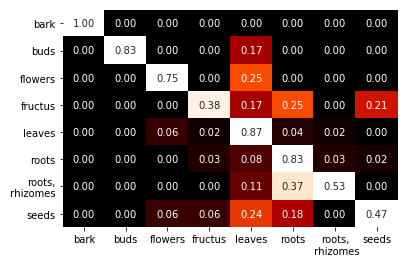

In [3]:
dirname_results = '../results/'
filename_results = 'autoencoder+NB_parts.npz'

df = np.load(dirname_results+filename_results)

confusion_matrices = df['confusion_matrices']
confusion_matrices = np.array(confusion_matrices)
medCMs = np.median(confusion_matrices, axis=0)

accuracies = df['acc']
accuracies = np.array(accuracies)

f1s = df['f1']
f1s = np.array(f1s)
print "accuracies"
print np.median(accuracies, axis=0)
print "f1 measure"
print np.median(f1s, axis=0)

clsnms = ['bark', 'buds', 'flowers', 'fructus', 'leaves', 'roots', 'roots,\n rhizomes', 'seeds']
df = pd.DataFrame(medCMs, columns=clsnms)
df['names'] = clsnms
df = df.set_index('names')
medCMs /= np.sum(medCMs, axis=1, keepdims=True)
msk1 = medCMs.copy()
np.fill_diagonal(msk1, 0.)
sns.heatmap(
    medCMs, annot=True, vmin=msk1.min(), vmax=1.05*msk1.max(),
    xticklabels=clsnms, yticklabels=clsnms, cbar=None,
    fmt='.2f', cmap='gist_heat', #mask=np.eye(len(clsnms))
)
plt.savefig('parts_ae+nb.pdf')

### 6. Hybrid Bayesian classifier with bnlearn

[Back to contents](#Contents)

In [10]:
rpy2.robjects.numpy2ri.activate()
rpy2.robjects.pandas2ri.activate()

bnlearn = importr('bnlearn')

data_dirname = '../data/'
dirname_results = '../results/'
filename_results = 'autoencoder+HBN_parts'
data_filename = 'autoencoded_dataset_parts.npz'
data_test2_filename = 'autoencoded_test2_parts.npz'

#filename_cv = 'cv_indices_parts.npz'
filename_cv = 'physical_cv_indices_parts.npz'

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']

df = np.load(data_dirname+data_test2_filename)
X_test2, y_test2 = df['data'], df['label']
y_test2 = reshape(y_test2, [-1, 1])

df = np.load(data_dirname+data_filename)
X, y = df['data'], df['label']
y = reshape(y, [-1, 1])
colnames = ['identity'] + ['V%d' % (i) for i in xrange(X.shape[-1])]

tms = []
predict_train_all = []
predict_test_all = []
predict_test2_all = []

confusion_matrices = []
accuracies = []
f1s = []

for k in xrange(len(train_indices)):
    train_index = train_indices[k]
    test_index = test_indices[k]
    dataset_train = np.hstack([y[train_index], X[k, train_index, :]])
    dataset_train = pd.DataFrame(dataset_train, columns=colnames)
    dataset_train['identity'] = dataset_train['identity'].apply(str)
    dmap = dataset_train.iloc[:, 0].apply(float).values
    dmap = np.unique(dmap)
    dataset_test = np.hstack([y[test_index], X[k, test_index, :]])
    dataset_test = pd.DataFrame(dataset_test, columns=colnames)
    dataset_test['identity'] = dataset_test['identity'].apply(str)
    dataset_test2 = np.hstack([y_test2, X_test2[k, :, :]])
    dataset_test2 = pd.DataFrame(dataset_test2, columns=colnames)
    dataset_test2['identity'] = dataset_test2['identity'].apply(str)
    
    tic = time.clock()
    hBN_structure = bnlearn.mmhc(dataset_train)
    toc = time.clock()
    tms_loc = [toc-tic]
    fitted_bn = bnlearn.bn_fit(hBN_structure, dataset_train, method='mle')
    
    tic = time.clock()
    predict_train = bnlearn.predict_bn_fit(
        fitted_bn, node='identity', data=dataset_train.iloc[:, 1:], method='bayes-lw'
    )
    
    predict_test = bnlearn.predict_bn_fit(
        fitted_bn, node='identity', data=dataset_test.iloc[:, 1:], method='bayes-lw'
    )
    
    toc = time.clock()
    predict_train = np.array(predict_train)-1
    predict_train = dmap[predict_train]
    acc_loc = [accuracy_score(y[train_index], predict_train)]
    f1_loc = [f1_score(y[train_index], predict_train, average='weighted')]
    predict_test = np.array(predict_test)-1
    predict_test = dmap[predict_test]
    acc_loc.append( accuracy_score(y[test_index], predict_test) )
    f1_loc.append(f1_score(y[test_index], predict_test, average='weighted') )
    tms_loc.append(toc-tic)
    predict_test2 = bnlearn.predict_bn_fit(
        fitted_bn, node='identity', data=dataset_test2.iloc[:, 1:], method='bayes-lw'
    )
    predict_test2 = np.array(predict_test2)-1
    predict_test2 = dmap[predict_test2]
    acc_loc.append( accuracy_score(y_test2, predict_test2) )
    f1_loc.append(f1_score(y_test2, predict_test2, average='weighted') )
    tms.append(tms_loc)
    predict_train_all.append( predict_train )
    predict_test_all.append( predict_test )
    predict_test2_all.append( predict_test2 )
    
    accuracies.append(acc_loc)
    f1s.append(f1_loc)
    
    np.savez_compressed(
        dirname_results+filename_results, tms=tms, predict_train=predict_train_all,
        predict_test=predict_test_all,
        predict_test2=predict_test2_all,
        test_indices=test_indices,
        train_indices=train_indices,
        y_test2=y_test2.T,
        y=y
    )

accuracies
[0.75711582 0.67575758 0.625     ]
f1 measure
[0.75246155 0.66496643 0.58113797]


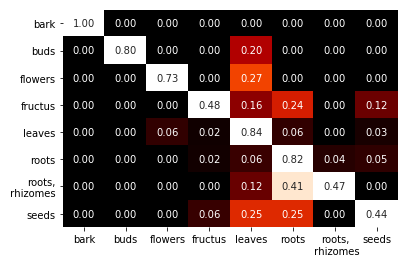

In [4]:
rpy2.robjects.numpy2ri.deactivate()
rpy2.robjects.pandas2ri.deactivate()

dirname_results = '../results/'
filename_results = 'autoencoder+HBN_parts.npz'

df = np.load(dirname_results+filename_results)

train_indices = df['train_indices']
test_indices = df['test_indices']
y = df['y']
y_test2 = df['y_test2'].flatten()
predict_train_all = df['predict_train']
predict_test_all = df['predict_test']
predict_test2_all = df['predict_test2']


accuracies = []
f1s = []
confusion_matrices = []

for i in xrange(len(test_indices)):
    train_index = train_indices[i]
    test_index = test_indices[i]
    acc_loc = []
    acc_loc.append(
        accuracy_score(y[train_index], predict_train_all[i])
    )
    acc_loc.append(
        accuracy_score(y[test_index], predict_test_all[i])
    )
    acc_loc.append(
        accuracy_score(y_test2, predict_test2_all[i])
    )
    f1_loc = []
    f1_loc.append(
        f1_score(y[train_index], predict_train_all[i], average='weighted')
    )
    f1_loc.append(
        f1_score(y[test_index], predict_test_all[i], average='weighted')
    )
    f1_loc.append(
        f1_score(y_test2, predict_test2_all[i], average='weighted')
    )
    accuracies.append( acc_loc )
    f1s.append( f1_loc )
    confusion_matrices.append(
        confusion_matrix(y[test_index], predict_test_all[i], labels=np.unique(y[train_index]))
    )

accuracies = np.array(accuracies)

f1s = np.array(f1s)
print "accuracies"
print np.median(accuracies, axis=0)
print "f1 measure"
print np.median(f1s, axis=0)


confusion_matrices = np.array(confusion_matrices)
medCMs = np.median(confusion_matrices, axis=0)

clsnms = ['bark', 'buds', 'flowers', 'fructus', 'leaves', 'roots', 'roots,\n rhizomes', 'seeds']
df = pd.DataFrame(medCMs, columns=clsnms)
df['names'] = clsnms
df = df.set_index('names')
medCMs /= np.sum(medCMs, axis=1, keepdims=True)
msk1 = medCMs.copy()
np.fill_diagonal(msk1, 0.)
sns.heatmap(
    medCMs, annot=True, vmin=msk1.min(), vmax=1.05*msk1.max(),
    xticklabels=clsnms, yticklabels=clsnms, cbar=None,
    fmt='.2f', cmap='gist_heat', #mask=np.eye(len(clsnms))
)

plt.savefig('parts_ae+hbn.pdf')